In [1]:
import pandas as pd
import numpy as np
import time
import json
from typing import Iterable, Dict, Any, List, Optional
import requests
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter


ModuleNotFoundError: No module named 'seaborn'

In [ ]:
def _props_dict(item):
    props = {}
    plist = (item.get("propertyConceptList") or {}).get("propertyConcept") or []
    for p in plist:
        k = (p.get("propName") or "").strip()
        v = (p.get("propValue") or "").strip()
        if k:
            props[k.upper()] = v
    return props

def _first_match(props, *keys_or_contains):
    for key in keys_or_contains:
        if key in props:
            return props[key]
    for key in props:
        for needle in keys_or_contains:
            if needle in key:
                return props[key]
    return None

def _rxnorm_names_from_rxcui(rxcui):
    base = "https://rxnav.nlm.nih.gov/REST"
    url = f"{base}/rxcui/{rxcui}/allProperties.json"
    resp = requests.get(url, params={"prop": "names"}, timeout=10)
    resp.raise_for_status()
    data = resp.json() or {}
    props = (data.get("propConceptGroup") or {}).get("propConcept") or []
    names = [(p.get("propName"), p.get("propValue")) for p in props]

    brand = None
    for code, val in names:
        if (code or "").upper() in ("BN", "SBD", "SBDF", "SBDG") and val:
            brand = val
            break

    generic = None
    for code, val in names:
        if (code or "").upper() in ("IN", "SCD", "SCDF", "SCDC") and val:
            generic = val
            break

    if generic is None:
        url2 = f"{base}/rxcui/{rxcui}/property.json"
        r2 = requests.get(url2, params={"propName": "RxNorm Name"}, timeout=10)
        if r2.ok:
            dd = r2.json() or {}
            generic = (dd.get("propConceptGroup") or {}).get("propConcept", [{}])[0].get("propValue")

    return brand, generic

def get_names_for_ndc(ndc_code, ndcstatus="ALL"):
    """
    Returns a dict with:
      - ndc11
      - brand_name
      - product_type
      - generic_name
      - labeler
      - rxcui
    Uses RxCUI fallbacks to fill brand/generic when missing in NDC properties.
    """
    ndc_url = "https://rxnav.nlm.nih.gov/REST/ndcproperties.json"
    r = requests.get(ndc_url, params={"id": ndc_code, "ndcstatus": ndcstatus}, timeout=10)
    r.raise_for_status()
    data = r.json() or {}
    items = (data.get("ndcPropertyList") or {}).get("ndcProperty") or []
    if not items:
        return {
            "ndc11": None,
            "brand_name": None,
            "product_type": None,
            "generic_name": None,
            "labeler": None,
            "rxcui": None,
        }

    # pick richest item (prefer one with explicit proprietary/nonproprietary if present)
    best = None
    for it in items:
        props = _props_dict(it)
        if "PROPRIETARYNAME" in props or "NONPROPRIETARYNAME" in props:
            best = it
            break
    if best is None:
        best = items[0]

    props = _props_dict(best)
    rxcui = best.get("rxcui")
    ndc11 = best.get("ndcItem")  # RxNav’s NDC11 field

    # direct reads
    brand = _first_match(props, "PROPRIETARYNAME", "PROPRIETARY NAME", "PROPRIETARY")
    generic = _first_match(props, "NONPROPRIETARYNAME", "NONPROPRIETARY NAME", "NONPROPRIETARY")
    product_type = _first_match(props, "PRODUCTTYPENAME", "PRODUCT TYPE")
    labeler = _first_match(props, "LABELER", "LABELERNAME", "LABELER NAME")

    # fallbacks via RxCUI
    if (not brand or not generic) and rxcui:
        rx_brand, rx_generic = _rxnorm_names_from_rxcui(rxcui)
        brand = brand or rx_brand
        generic = generic or rx_generic

    return {
        "ndc11": ndc11,
        "brand_name": brand,
        "product_type": product_type,   # e.g., HUMAN PRESCRIPTION DRUG
        "generic_name": generic,
        "labeler": labeler,
        "rxcui": rxcui,
    }

# ---- Example usage
if __name__ == "__main__":
    summary = get_names_for_ndc("00003-0894", ndcstatus="ALL")

print("NDC11:", summary["ndc11"])
print("Brand name:", summary["brand_name"])
print("Product type:", summary["product_type"])
print("Generic name:", summary["generic_name"])
print("Labeler:", summary["labeler"])
print("RxCUI:", summary["rxcui"])


NDC11: 00003089421
Brand name: None
Product type: None
Generic name: apixaban 5 MG Oral Tablet [Eliquis]
Labeler: E.R. Squibb & Sons, L.L.C.
RxCUI: 1364447


In [ ]:
df=pd.read_csv('SDUD2021.csv',low_memory=False)
print(df.columns)
ndc_codes=df['NDC'].unique()
print(len(ndc_codes))

Index(['Utilization Type', 'State', 'NDC', 'Labeler Code', 'Product Code',
       'Package Size', 'Year', 'Quarter', 'Suppression Used', 'Product Name',
       'Units Reimbursed', 'Number of Prescriptions',
       'Total Amount Reimbursed', 'Medicaid Amount Reimbursed',
       'Non Medicaid Amount Reimbursed'],
      dtype='object')
49832


The percentage given in the lines:     
- print(f"\nYear {year}: Comparison with 'XX' (relative to XX values):")

- print(f"Units Reimbursed - Total: {total_units:.3f} B | XX: {xx_units:.3f} B | % diff: {units_diff_pct:.2f}%")

- print(f"Number of Prescriptions - Total: {total_prescriptions:.3f} M | XX: {xx_prescriptions:.3f} M | % diff: {presc_diff_pct:.2f}%")

total_units:.3f B → how many billions of units you got by summing all the states.

xx_units:.3f B → how many billions of units are reported by Medicaid under 'XX'. This is, the national total that Medicaid gives directly

e.g: “When I add up all the states, I get 30.5 billion units.
Medicaid’s national number (XX) is 31.2 billion units.
My total is about 2.4% smaller than theirs.”

In [ ]:
# Read CSV and show dataframe (and NA subset) as tables instead of raw CSV text
file_path = 'SDUD2024.csv'  # change as needed

df = pd.read_csv(file_path, low_memory=False)

cols = ['Units Reimbursed', 'Number of Prescriptions']
missing_available = [c for c in cols if c in df.columns]

print(f"Full dataframe shape: {df.shape}")
#display(df)  # uncomment to view entire table (heavy)

# Show rows with State == 'XX'
if 'State' in df.columns:
    xx_rows = df[df['State'] == 'XX']
    print(f"Rows with State='XX': {len(xx_rows)}")
    if xx_rows.empty:
        print("No rows with State='XX'.")
    else:
        print("First 10 rows with State='XX':")
        display(xx_rows.head(10))

if len(missing_available) < 2:
    print("Required columns missing:", [c for c in cols if c not in df.columns])
else:
    na_subset = df[df['Units Reimbursed'].isna() | df['Number of Prescriptions'].isna()]
    print(f"Rows with NA in at least one target column: {len(na_subset)}")
    if na_subset.empty:
        print("No missing values in target columns.")
    else:
        print("First 10 NA rows:")
        display(na_subset.head(10))

    # Optional exports:
    # xx_rows.to_csv('state_xx_rows.csv', index=False)
    # na_subset.to_csv('na_rows_full.csv', index=False)


Full dataframe shape: (4789471, 15)
Rows with State='XX': 273429
First 10 rows with State='XX':


,Utilization Type,State,NDC,Labeler Code,Product Code,Package Size,Year,Quarter,Suppression Used,Product Name,Units Reimbursed,Number of Prescriptions,Total Amount Reimbursed,Medicaid Amount Reimbursed,Non Medicaid Amount Reimbursed
2425490,MCOU,XX,00002120001,2,1200,01,2017,4,True,AMYVID,NaN,NaN,NaN,NaN,NaN
2425491,MCOU,XX,00002140701,2,1407,01,2017,4,True,QUINIDINE,NaN,NaN,NaN,NaN,NaN
2425492,FFSU,XX,00002143301,2,1433,01,2017,4,True,TRULICITY,NaN,NaN,NaN,NaN,NaN
2425493,MCOU,XX,00002143301,2,1433,01,2017,4,False,TRULICITY,147.5,74.0,49338.06,49326.06,12.00
2425494,FFSU,XX,00002143380,2,1433,80,2017,4,False,TRULICITY,6366.0,2914.0,2016000.35,1933616.22,82384.13
2425495,MCOU,XX,00002143380,2,1433,80,2017,4,False,TRULICITY,36295.0,17900.0,12209139.56,12077891.81,131247.75
2425496,FFSU,XX,00002143401,2,1434,01,2017,4,True,TRULICITY,NaN,NaN,NaN,NaN,NaN
2425497,MCOU,XX,00002143401,2,1434,01,2017,4,False,TRULICITY,88.0,47.0,29419.88,29413.88,6.00
2425498,FFSU,XX,00002143480,2,1434,80,2017,4,False,TRULICITY,10006.0,4344.0,3076313.26,2958298.07,118015.19
2425499,MCOU,XX,00002143480,2,1434,80,2017,4,False,TRULICITY,44950.5,22006.0,15087266.12,14893782.67,193483.45


Rows with NA in at least one target column: 2271518
First 10 NA rows:


,Utilization Type,State,NDC,Labeler Code,Product Code,Package Size,Year,Quarter,Suppression Used,Product Name,Units Reimbursed,Number of Prescriptions,Total Amount Reimbursed,Medicaid Amount Reimbursed,Non Medicaid Amount Reimbursed
2,FFSU,AK,00002144511,2,1445,11,2017,4,True,TALTZ AUTO,NaN,NaN,NaN,NaN,NaN
3,FFSU,AK,00002322730,2,3227,30,2017,4,True,STRATTERA,NaN,NaN,NaN,NaN,NaN
6,FFSU,AK,00002323560,2,3235,60,2017,4,True,CYMBALTA,NaN,NaN,NaN,NaN,NaN
7,FFSU,AK,00002323830,2,3238,30,2017,4,True,STRATTERA,NaN,NaN,NaN,NaN,NaN
8,FFSU,AK,00002323930,2,3239,30,2017,4,True,STRATTERA,NaN,NaN,NaN,NaN,NaN
9,FFSU,AK,00002324030,2,3240,30,2017,4,True,CYMBALTA,NaN,NaN,NaN,NaN,NaN
10,FFSU,AK,00002324090,2,3240,90,2017,4,True,CYMBALTA,NaN,NaN,NaN,NaN,NaN
11,FFSU,AK,00002325030,2,3250,30,2017,4,True,STRATTERA,NaN,NaN,NaN,NaN,NaN
12,FFSU,AK,00002325130,2,3251,30,2017,4,True,STRATTERA,NaN,NaN,NaN,NaN,NaN
13,FFSU,AK,00002327030,2,3270,30,2017,4,True,CYMBALTA,NaN,NaN,NaN,NaN,NaN


In [2]:

#Final function for drug utilization data processing

def preliminar(file_path):
    
    year = file_path[4:8]

    df = pd.read_csv(file_path,low_memory=False)
    print(f"\nYear {year}: Initial rows: {len(df)}")
    required_cols = ['State', 'NDC', 'Units Reimbursed', 'Number of Prescriptions']
    existing = [c for c in required_cols if c in df.columns]
    if existing:
        before = len(df)
        df = df.dropna(subset=existing)
        dropped = before - len(df)
        print(f"Year {year}: Dropped {dropped} rows with NA in {existing}")
    else:
        print(f"Year {year}: Required columns missing, skip NA drop")

    print(f"Year {year}: Total rows after NA drop: {len(df)}")

    df_xx = df[df['State'] == 'XX']
    print(f"Year {year}: Rows with invalid state code 'XX': {len(df_xx)}")

    df = df[df['State'] != 'XX']
    print(f"Year {year}: Rows after removing invalid state code 'XX': {len(df)}")

    df['Units Reimbursed'] = pd.to_numeric(df['Units Reimbursed'], errors='coerce')/1e9
    df['Number of Prescriptions'] = pd.to_numeric(df['Number of Prescriptions'], errors='coerce')/1e6

    state_summary = df.groupby('State')[['Units Reimbursed', 'Number of Prescriptions']].sum()
    #print(f"\nYear {year}: State Summary:")

    total_units = state_summary['Units Reimbursed'].sum()
    total_prescriptions = state_summary['Number of Prescriptions'].sum()
    print(f"\nYear {year}: Total Units Reimbursed across all states: {total_units}")
    print(f"Year {year}: Total Number of Prescriptions across all states: {total_prescriptions}")

    top_states_units = state_summary.sort_values(by='Units Reimbursed', ascending=False).head(10)
    print(f"\nYear {year}: Top 10 States by Units Reimbursed:")
    print(top_states_units)

    top_states_prescriptions = state_summary.sort_values(by='Number of Prescriptions', ascending=False).head(10)
    print(f"\nYear {year}: Top 10 States by Number of Prescriptions:")
    print(top_states_prescriptions)

    # 'XX' invalid state code analysis with proper scaling
    wp = df_xx[['State', 'Units Reimbursed', 'Number of Prescriptions']].copy()
    if not wp.empty:
        wp['Units Reimbursed'] = pd.to_numeric(wp['Units Reimbursed'], errors='coerce') / 1e9  # billions
        wp['Number of Prescriptions'] = pd.to_numeric(wp['Number of Prescriptions'], errors='coerce') / 1e6  # millions
        wp_summary = wp.groupby('State')[['Units Reimbursed', 'Number of Prescriptions']].sum()
        print(f"\nYear {year}: Summary for rows with invalid state code 'XX' (scaled):")
        print(wp_summary)

        xx_units = wp_summary['Units Reimbursed'].iloc[0]
        xx_prescriptions = wp_summary['Number of Prescriptions'].iloc[0]

        units_diff_pct = ((total_units - xx_units) / xx_units * 100) if xx_units else float('nan')
        presc_diff_pct = ((total_prescriptions - xx_prescriptions) / xx_prescriptions * 100) if xx_prescriptions else float('nan')

        print(f"\nYear {year}: Comparison with 'XX' (relative to XX values):")
        print(f"Units Reimbursed - Total: {total_units:.3f} B | XX: {xx_units:.3f} B | % diff: {units_diff_pct:.2f}%")
        print(f"Number of Prescriptions - Total: {total_prescriptions:.3f} M | XX: {xx_prescriptions:.3f} M | % diff: {presc_diff_pct:.2f}%")
    else:
        print(f"\nYear {year}: No data available for state code 'XX'.")

    correlation = state_summary['Units Reimbursed'].corr(state_summary['Number of Prescriptions'])
    print(f"\nYear {year}: Correlation between 'Units Reimbursed' and 'Number of Prescriptions': {correlation:.2f}")

# Inputs for multiple years (datasets)
#preliminar('SDUD2010.csv')
#preliminar('SDUD2011.csv')
#preliminar('SDUD2012.csv')
#preliminar('SDUD2013.csv')
#preliminar('SDUD2014.csv')
#preliminar('SDUD2015.csv')
#preliminar('SDUD2016.csv')
#preliminar('SDUD2017.csv')
#preliminar('SDUD2018.csv')
#preliminar('SDUD2019.csv')
#preliminar('SDUD2020.csv')
#preliminar('SDUD2021.csv')
#preliminar('SDUD2022.csv')
#preliminar('SDUD2023.csv')
preliminar('SDUD2024.csv')



Year 2024: Initial rows: 5205065
Year 2024: Dropped 2605317 rows with NA in ['State', 'NDC', 'Units Reimbursed', 'Number of Prescriptions']
Year 2024: Total rows after NA drop: 2599748
Year 2024: Rows with invalid state code 'XX': 237118
Year 2024: Rows after removing invalid state code 'XX': 2362630

Year 2024: Total Units Reimbursed across all states: 46.335984324556
Year 2024: Total Number of Prescriptions across all states: 729.4256340000001

Year 2024: Top 10 States by Units Reimbursed:
       Units Reimbursed  Number of Prescriptions
State                                           
CA             7.008662                89.943110
NY             4.756533                73.091017
OH             2.311147                36.582261
KY             2.174252                42.948051
TX             2.060070                27.303055
PA             1.996656                32.177001
MI             1.564113                28.453759
FL             1.556920                22.726016
NC          

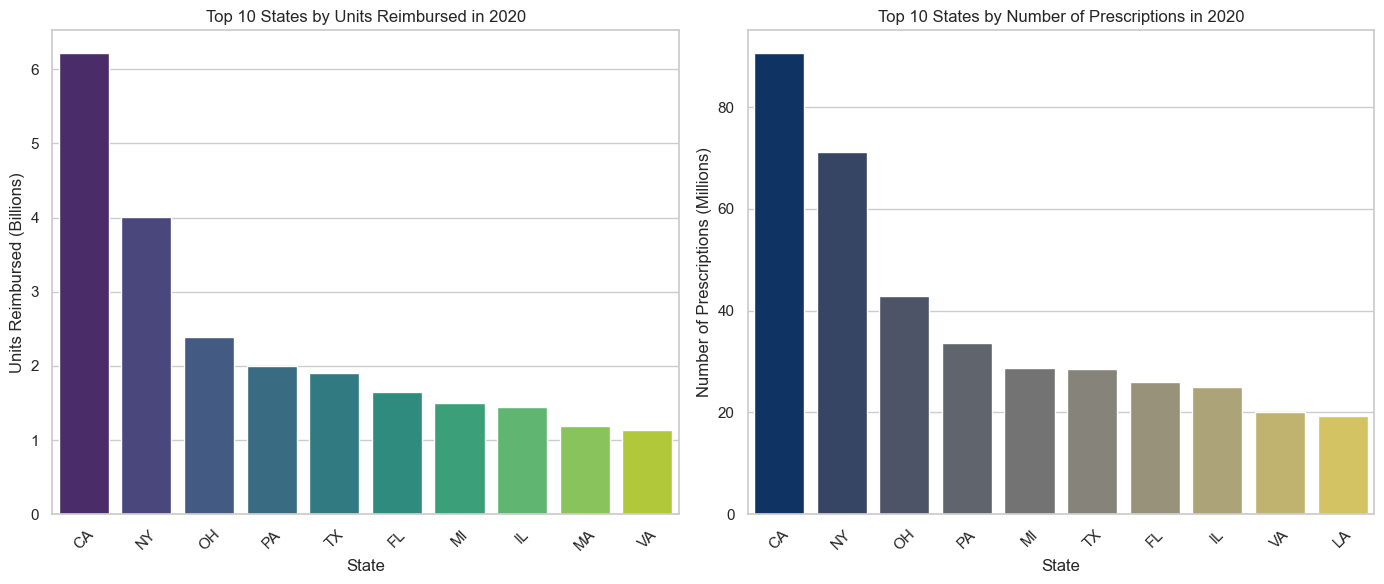

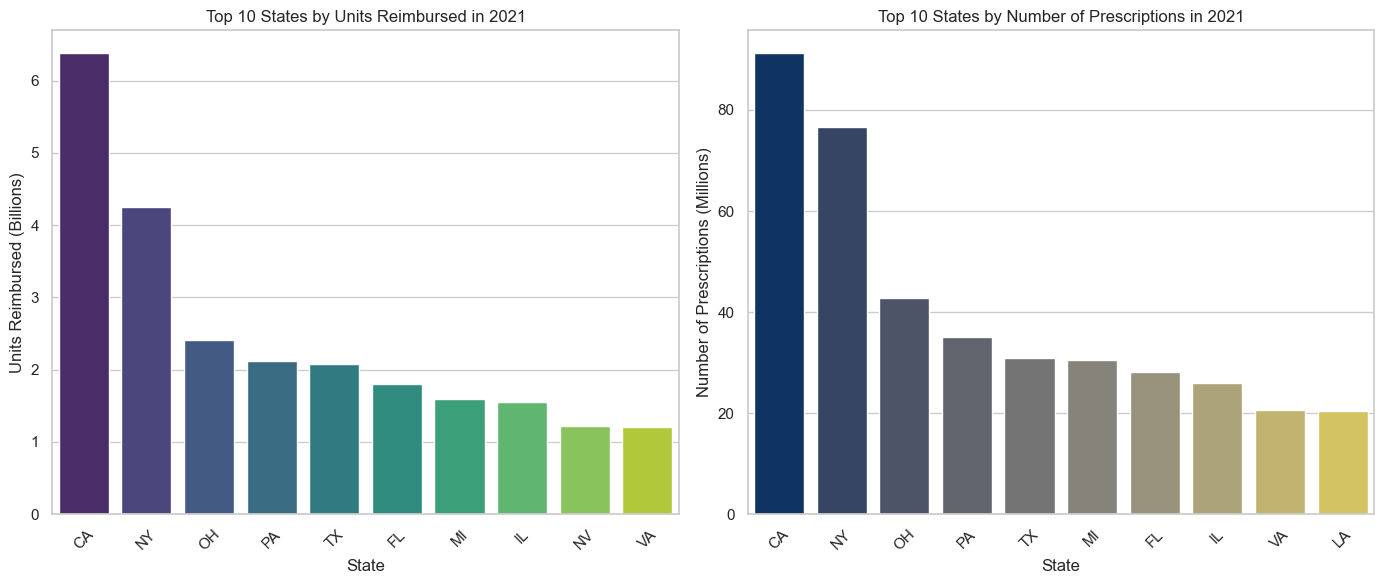

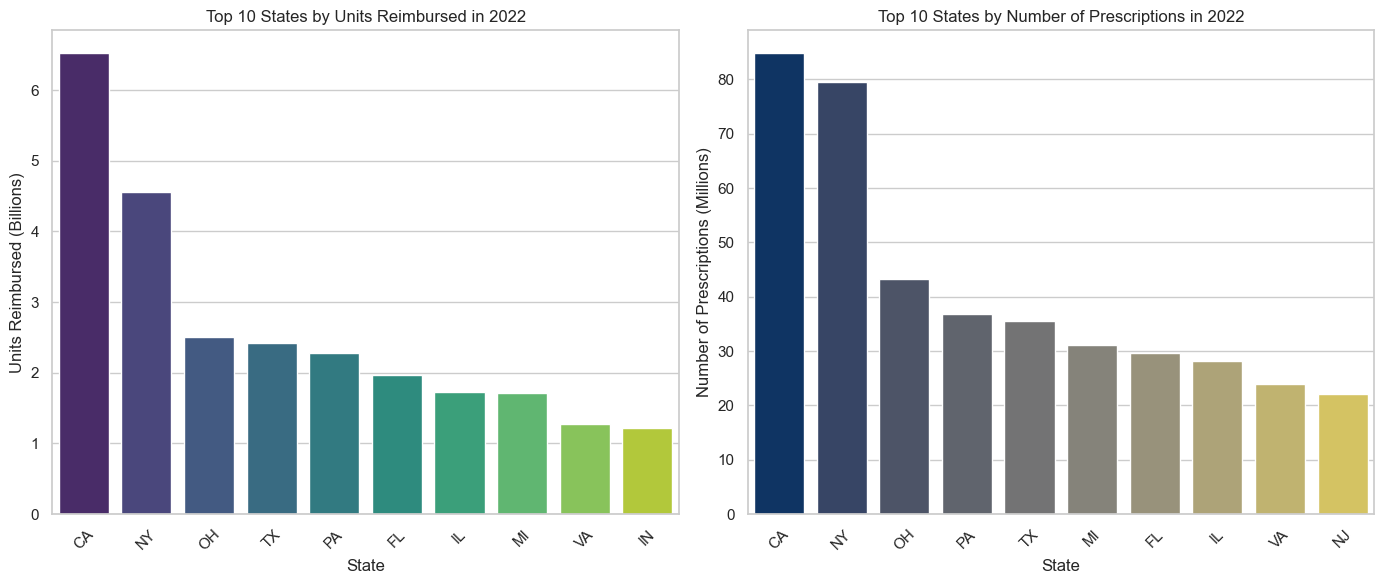

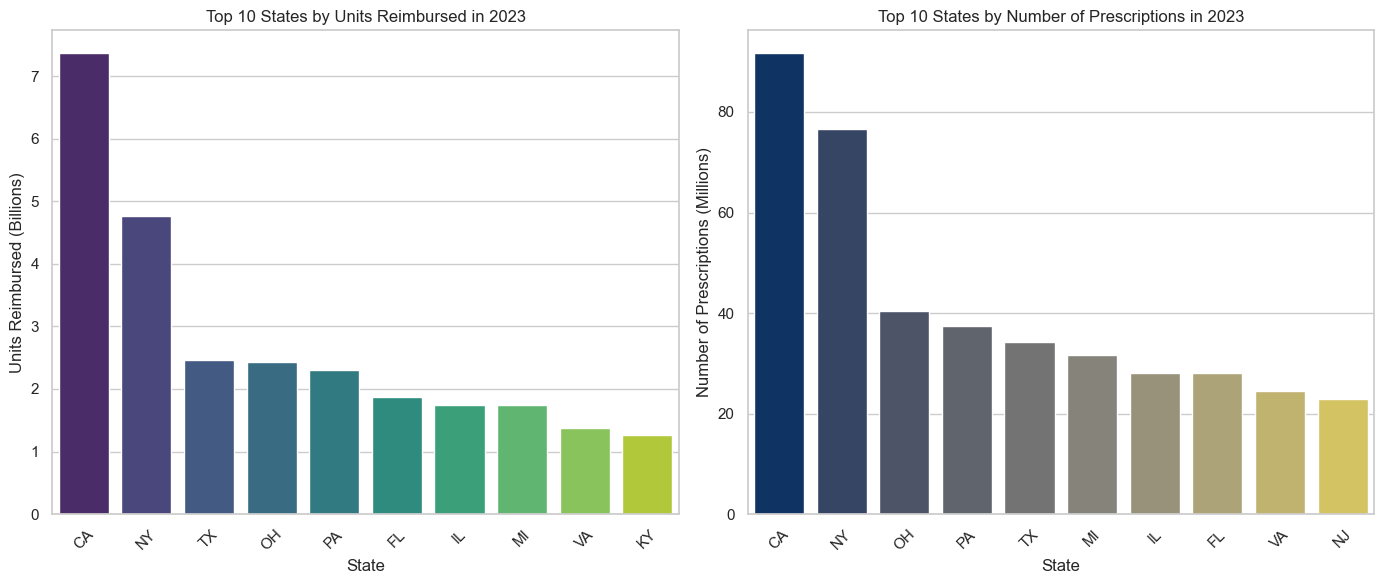

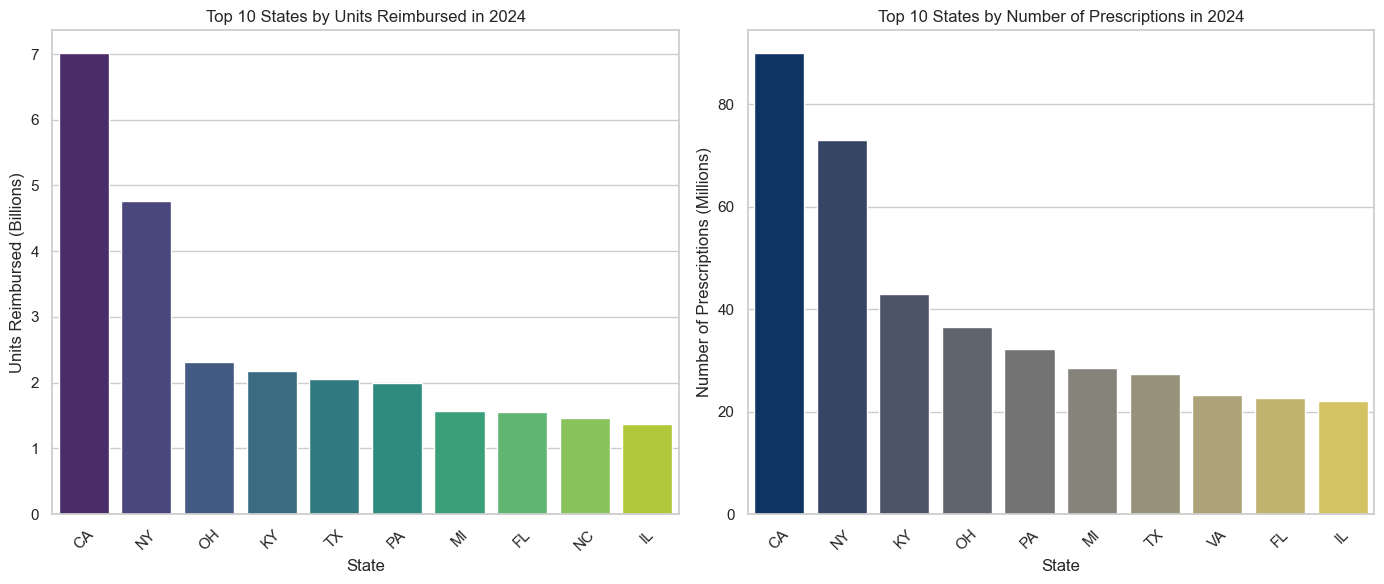

In [ ]:
# plotting the top-ten states by category for a given year
# This is before normalization by population 
# Patch seaborn.barplot to avoid deprecation warning (palette without hue)

if not getattr(sns, '_auto_hue_patched', False):
    _orig_barplot = sns.barplot
    def _barplot_auto_hue(*args, **kwargs):
        has_palette = kwargs.get('palette') is not None
        missing_hue = 'hue' not in kwargs or kwargs['hue'] is None
        x_var = kwargs.get('x')
        if has_palette and missing_hue and x_var is not None:
            kwargs['hue'] = x_var
            kwargs.setdefault('legend', False)
            kwargs.setdefault('dodge', False)
        return _orig_barplot(*args, **kwargs)
    sns.barplot = _barplot_auto_hue
    sns._auto_hue_patched = True
def plot_top_ten_states(file_path):
    """
    Reads a CSV file, processes the drug utilization data, and plots the top ten states by Units Reimbursed and Number of Prescriptions.
    """
    year = file_path[4:8]

    df = pd.read_csv(file_path, low_memory=False)
    df = df[df['State'] != 'XX']
    state_summary = df.groupby('State')[['Units Reimbursed', 'Number of Prescriptions']].sum()

    U_factor=1e9 #Billions
    P_factor=1e6 #Millions

    state_summary['Units Reimbursed'] = state_summary['Units Reimbursed'] / U_factor
    state_summary['Number of Prescriptions'] = state_summary['Number of Prescriptions'] / P_factor

    top_states_units = state_summary.sort_values(by='Units Reimbursed', ascending=False).head(10)
    top_states_prescriptions = state_summary.sort_values(by='Number of Prescriptions', ascending=False).head(10)

    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    sns.barplot(x=top_states_units.index, y=top_states_units['Units Reimbursed'], palette='viridis')
    plt.title(f'Top 10 States by Units Reimbursed in {year}')
    plt.xlabel('State')
    plt.ylabel('Units Reimbursed (Billions)')
    plt.xticks(rotation=45)

    plt.subplot(1, 2, 2)
    sns.barplot(x=top_states_prescriptions.index, y=top_states_prescriptions['Number of Prescriptions'], palette='cividis')
    plt.title(f'Top 10 States by Number of Prescriptions in {year}')
    plt.xlabel('State')
    plt.ylabel('Number of Prescriptions (Millions)')
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

# Example usage for plotting
plot_top_ten_states('SDUD2020.csv')
plot_top_ten_states('SDUD2021.csv')
plot_top_ten_states('SDUD2022.csv')
plot_top_ten_states('SDUD2023.csv')
plot_top_ten_states('SDUD2024.csv')


In [ ]:

# Looking at position changes between the two categories, states that appear in only one category, and frequency of appearances across years
# Table formatting fpr top-N states by category per year
# This is before normalization by population (next snippet)

top_n = 10
records = []

# Prefer already-built utilization dataframe (cell 5); fallback to CSVs
if 'util_df' in globals():
    years_iter = sorted(util_df['Year'].unique())
    def iter_year_data():
        for yr in years_iter:
            df_year = util_df[util_df['Year'] == yr].set_index('State')[['Units Reimbursed','Number of Prescriptions']]
            yield yr, df_year
else:
    if 'csv_files' in globals():
        file_paths = csv_files
    else:
        file_paths = [f"SDUD{y}.csv" for y in range(2010, 2025)]
    def iter_year_data():
        for fp in file_paths:
            yr = int(fp[4:8])
            df_year = pd.read_csv(fp, low_memory=False)
            # Clean
            need = ['State','Units Reimbursed','Number of Prescriptions']
            have = [c for c in need if c in df_year.columns]
            if have:
                df_year = df_year.dropna(subset=have)
            if 'State' in df_year.columns:
                df_year = df_year[df_year['State'] != 'XX']
            df_year = (df_year
                       .groupby('State')[['Units Reimbursed','Number of Prescriptions']]
                       .sum())
            yield yr, df_year

for year, state_summary in iter_year_data():
    if state_summary.empty:
        continue

    # Top-N lists
    top_units = (state_summary
                 .sort_values('Units Reimbursed', ascending=False)
                 .head(top_n))
    top_presc = (state_summary
                 .sort_values('Number of Prescriptions', ascending=False)
                 .head(top_n))

    units_order = list(top_units.index)
    presc_order = list(top_presc.index)
    rank_units = {s: i+1 for i, s in enumerate(units_order)}
    rank_presc = {s: i+1 for i, s in enumerate(presc_order)}

    all_states = list(dict.fromkeys(units_order + presc_order))  # preserve order: units first then new from prescriptions

    print(f"\nYear {year}: Rank Comparison (Top {top_n})")
    print("State | Rank Units | Rank Prescriptions | Same Position | Appearance")
    for s in all_states:
        ru = rank_units.get(s)
        rp = rank_presc.get(s)
        if ru and rp:
            same = (ru == rp)
            appearance = "Both"
        elif ru and not rp:
            same = False
            appearance = "Units only"
        else:
            same = False
            appearance = "Prescriptions only"
        print(f"{s:>4}  | {str(ru or '-'):>10} | {str(rp or '-'):>18} | {str(same):>13} | {appearance}")

    # Store records
    for i, s in enumerate(units_order, start=1):
        records.append({'Year': year, 'Category': 'Units Reimbursed', 'Rank': i, 'State': s})
    for i, s in enumerate(presc_order, start=1):
        records.append({'Year': year, 'Category': 'Number of Prescriptions', 'Rank': i, 'State': s})

# Build DataFrame of all rankings
top_states_df = pd.DataFrame(records)

# Frequency counters across all years
top_states_counter_units = Counter(r['State'] for r in records if r['Category'] == 'Units Reimbursed')
top_states_counter_prescriptions = Counter(r['State'] for r in records if r['Category'] == 'Number of Prescriptions')

print("\nStates frequency in Top Units Reimbursed (across years):")
print(top_states_counter_units.most_common())

print("\nStates frequency in Top Number of Prescriptions (across years):")
print(top_states_counter_prescriptions.most_common())

# identify states that ever appeared only in one metric in a year
exclusive_records = []
for year in top_states_df['Year'].unique():
    u = set(top_states_df[(top_states_df.Year==year) & (top_states_df.Category=='Units Reimbursed')]['State'])
    p = set(top_states_df[(top_states_df.Year==year) & (top_states_df.Category=='Number of Prescriptions')]['State'])
    only_units = u - p
    only_presc = p - u
    for s in sorted(only_units):
        exclusive_records.append({'Year': year, 'State': s, 'Exclusive': 'Units'})
    for s in sorted(only_presc):
        exclusive_records.append({'Year': year, 'State': s, 'Exclusive': 'Prescriptions'})

exclusive_df = pd.DataFrame(exclusive_records).sort_values(['Year','Exclusive','State'])
print("\nStates appearing exclusively in one top-10 list per year:")
print(exclusive_df if not exclusive_df.empty else "None")



Year 2010: Rank Comparison (Top 10)
State | Rank Units | Rank Prescriptions | Same Position | Appearance
  NY  |          1 |                  1 |          True | Both
  CA  |          2 |                  2 |          True | Both
  TX  |          3 |                  3 |          True | Both
  IL  |          4 |                  4 |          True | Both
  FL  |          5 |                  6 |         False | Both
  OH  |          6 |                  5 |         False | Both
  NC  |          7 |                  8 |         False | Both
  IN  |          8 |                  - |         False | Units only
  MI  |          9 |                  9 |          True | Both
  PA  |         10 |                  7 |         False | Both
  MO  |          - |                 10 |         False | Prescriptions only

Year 2011: Rank Comparison (Top 10)
State | Rank Units | Rank Prescriptions | Same Position | Appearance
  CA  |          1 |                  2 |         False | Both
  NY  |     

In [ ]:
#Using population data (BOTH DATASETS)
# Load population data (2010-2019 and 2020-2024)

pop0_df = pd.read_excel("../Population/20102020_pop.xlsx", engine="openpyxl")
pop1_df = pd.read_excel("../Population/20202024_pop.xlsx", engine="openpyxl")


def _clean_pop(df):
    df = df.copy()
    df['Geographic Area'] = df['Geographic Area'].str.replace('.', '', regex=False).str.strip()
    return df

pop0_df = _clean_pop(pop0_df)
pop1_df = _clean_pop(pop1_df)

# Combine year columns horizontally by Geographic Area
pop_df = pop0_df.merge(pop1_df, on='Geographic Area', how='outer')

# Drop totally empty area rows
pop_df = pop_df[pop_df['Geographic Area'].notna()].reset_index(drop=True)

# Coerce numeric columns
for c in pop_df.columns:
    if c != 'Geographic Area':
        pop_df[c] = pd.to_numeric(pop_df[c], errors='coerce')

# Order columns: Geographic Area, then years (keeping B before final year where applicable)
def _col_key(c):
    if c == 'Geographic Area':
        return (0, 0, 0)
    sc = str(c)
    base = sc.rstrip('B')
    if base.isdigit():
        return (1, int(base), 0 if sc.endswith('B') else 1)
    return (2, sc, 0)

ordered_cols = ['Geographic Area'] + sorted([c for c in pop_df.columns if c != 'Geographic Area'], key=_col_key)
pop_df = pop_df[ordered_cols]

print(pop_df.head())

  Geographic Area       2010B        2010        2011        2012        2013  \
0         Alabama   4780118.0   4788095.0   4812576.0   4839947.0   4865253.0   
1          Alaska    710246.0    714015.0    722513.0    731106.0    738054.0   
2         Arizona   6392292.0   6401304.0   6443158.0   6501800.0   6555926.0   
3        Arkansas   2916029.0   2921546.0   2938773.0   2948793.0   2954563.0   
4      California  37254522.0  37322523.0  37651212.0  37971412.0  38292557.0   

         2014        2015        2016        2017        2018        2019  \
0   4887757.0   4909177.0   4931579.0   4953096.0   4977088.0   5003778.0   
1    737634.0    739120.0    743397.0    741937.0    737710.0    734820.0   
2   6629890.0   6705607.0   6793278.0   6872380.0   6964300.0   7067695.0   
3   2961050.0   2970210.0   2980475.0   2990702.0   2997195.0   3004206.0   
4  38637421.0  38966939.0  39223789.0  39424315.0  39535920.0  39547995.0   

        2020B        2020        2021        2022 

In [ ]:
# Merging datasets: Drug Utilization + Population
# Mormalization by population data

from pathlib import Path

# 1. Aggregate utilization per State-Year
def build_utilization_dataframe(file_paths):
    frames = []
    usecols = ['State','Units Reimbursed','Number of Prescriptions']
    for fp in file_paths:
        year = int(Path(fp).stem[-4:])  # assumes pattern SDUDYYYY.csv
        df = pd.read_csv(fp, usecols=usecols, low_memory=False)
        df = df[df['State'].ne('XX')]  # drop invalid
        state_summary = df.groupby('State', as_index=False).sum()
        state_summary['Year'] = year
        frames.append(state_summary)
    return pd.concat(frames, ignore_index=True)

csv_years = list(range(2010, 2025))  # adjust if more years available
csv_files = [f"SDUD{y}.csv" for y in csv_years]
util_df = build_utilization_dataframe(csv_files)

# 2. Reshape population data to long format (ensure pop_df already loaded earlier)
# CHANGED: coerce column name to str before isdigit() to avoid AttributeError on int columns; keep only 4-digit years
pop_year_cols = [c for c in pop_df.columns if str(c).isdigit() and len(str(c)) == 4]
pop_long = pop_df.melt(id_vars=['Geographic Area'], value_vars=pop_year_cols,
                       var_name='Year', value_name='Population')
pop_long['Year'] = pop_long['Year'].astype(int)

# 3. Map full state names to postal abbreviations
state_map = {
 'AL':'Alabama','AK':'Alaska','AZ':'Arizona','AR':'Arkansas','CA':'California','CO':'Colorado','CT':'Connecticut',
 'DE':'Delaware','DC':'District of Columbia','FL':'Florida','GA':'Georgia','HI':'Hawaii','ID':'Idaho','IL':'Illinois',
 'IN':'Indiana','IA':'Iowa','KS':'Kansas','KY':'Kentucky','LA':'Louisiana','ME':'Maine','MD':'Maryland','MA':'Massachusetts',
 'MI':'Michigan','MN':'Minnesota','MS':'Mississippi','MO':'Missouri','MT':'Montana','NE':'Nebraska','NV':'Nevada','NH':'New Hampshire',
 'NJ':'New Jersey','NM':'New Mexico','NY':'New York','NC':'North Carolina','ND':'North Dakota','OH':'Ohio','OK':'Oklahoma','OR':'Oregon',
 'PA':'Pennsylvania','RI':'Rhode Island','SC':'South Carolina','SD':'South Dakota','TN':'Tennessee','TX':'Texas','UT':'Utah','VT':'Vermont',
 'VA':'Virginia','WA':'Washington','WV':'West Virginia','WI':'Wisconsin','WY':'Wyoming'
}
full_to_abbrev = {v:k for k,v in state_map.items()}
pop_long['State'] = pop_long['Geographic Area'].map(full_to_abbrev)
pop_long = pop_long.dropna(subset=['State'])

# 4. Keep only population years that exist in utilization
pop_long = pop_long[pop_long['Year'].isin(util_df['Year'].unique())]

# 5. Merge
merged = util_df.merge(pop_long[['State','Year','Population']], on=['State','Year'], how='left')

# 6. Reorder + add normalized columns
merged = merged[['State','Year','Population','Units Reimbursed','Number of Prescriptions']]

merged['N Prescriptions norm'] = merged['Number of Prescriptions'] / merged['Population']
merged['N Units reimbursed norm'] = merged['Units Reimbursed'] / merged['Population']

# 7. Inspect
print(merged.head())
print('\nShape:', merged.shape)

# Just checking
only2010 = merged[merged['Year']==2010]
onlyIN= merged[merged['State']=='WV']
#print(only2010)
print('\n2010 Shape:', only2010.shape)
print(onlyIN)
# 'merged' now contains the requested combined dataframe


  State  Year  Population  Units Reimbursed  Number of Prescriptions  \
0    AK  2010    714015.0      4.610507e+07                1006168.0   
1    AL  2010   4788095.0      4.821577e+08                8525050.0   
2    AR  2010   2921546.0      2.908855e+08                4788392.0   
3    AZ  2010   6401304.0      6.108745e+08               10514315.0   
4    CA  2010  37322523.0      3.313082e+09               47209227.0   

   N Prescriptions norm  N Units reimbursed norm  
0              1.409169                64.571570  
1              1.780468               100.699285  
2              1.638993                99.565613  
3              1.642527                95.429691  
4              1.264899                88.768972  

Shape: (767, 7)

2010 Shape: (51, 7)
    State  Year  Population  Units Reimbursed  Number of Prescriptions  \
49     WV  2010   1854404.0      3.286600e+08                5977694.0   
100    WV  2011   1857305.0      3.320692e+08                6071422.0   
1


Correlation between 'N Units reimbursed norm' and 'N Prescriptions norm': 0.49


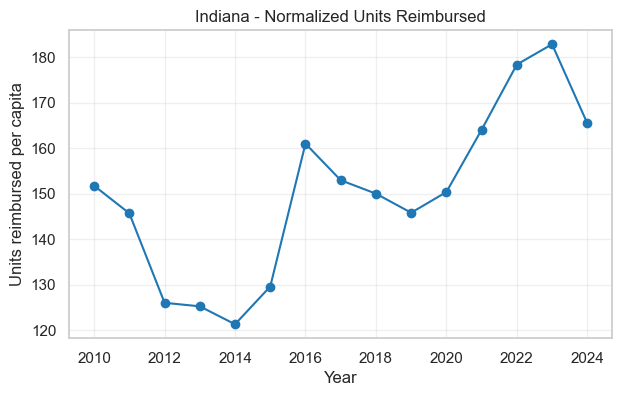

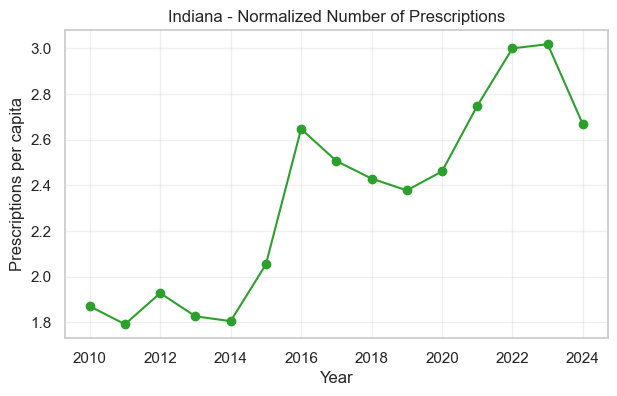

In [ ]:
# look at correlations and patterns in normalized data

corr_pop = merged['N Units reimbursed norm'].corr(merged['N Prescriptions norm'])
print(f"\nCorrelation between 'N Units reimbursed norm' and 'N Prescriptions norm': {corr_pop:.2f}")
# Filter data for Indiana
indiana_data = merged.loc[merged['State'] == 'IN'].sort_values('Year').dropna(
    subset=['N Units reimbursed norm', 'N Prescriptions norm']
)

# Line chart 1: Normalized Units Reimbursed
plt.figure(figsize=(7,4))
plt.plot(indiana_data['Year'], indiana_data['N Units reimbursed norm'], marker='o', color='tab:blue')
plt.title('Indiana - Normalized Units Reimbursed')
plt.xlabel('Year')
plt.ylabel('Units reimbursed per capita')
plt.grid(alpha=0.3)

# Line chart 2: Normalized Number of Prescriptions
plt.figure(figsize=(7,4))
plt.plot(indiana_data['Year'], indiana_data['N Prescriptions norm'], marker='o', color='tab:green')
plt.title('Indiana - Normalized Number of Prescriptions')
plt.xlabel('Year')
plt.ylabel('Prescriptions per capita')
plt.grid(alpha=0.3)

(<Figure size 1400x600 with 2 Axes>,
 array([<Axes: title={'center': '2024 Top 10: Prescriptions per capita'}, xlabel='State', ylabel='Prescriptions per capita'>,
        <Axes: title={'center': '2024 Top 10: Units reimbursed per capita'}, xlabel='State', ylabel='Units reimbursed per capita'>],
       dtype=object))

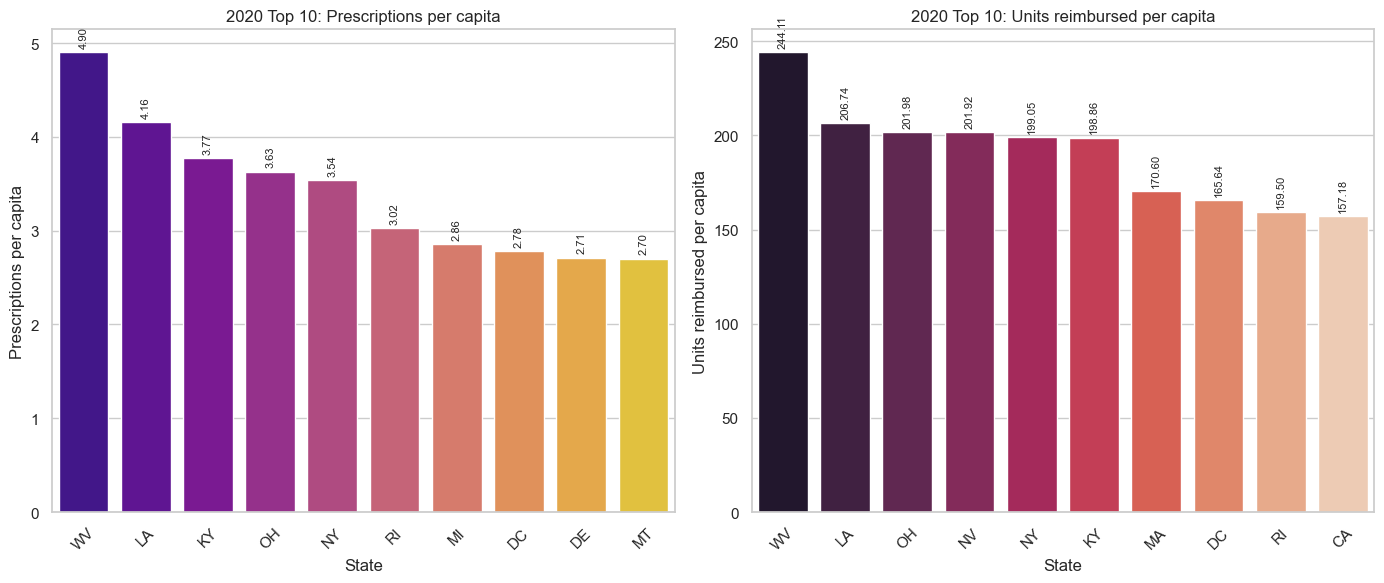

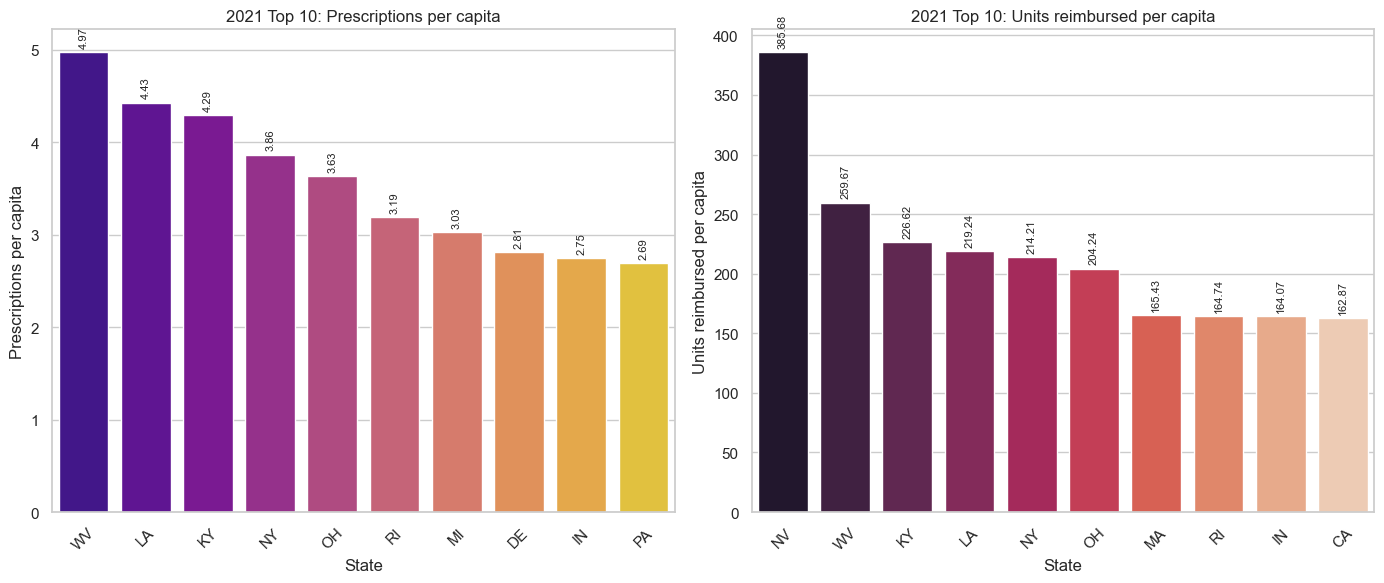

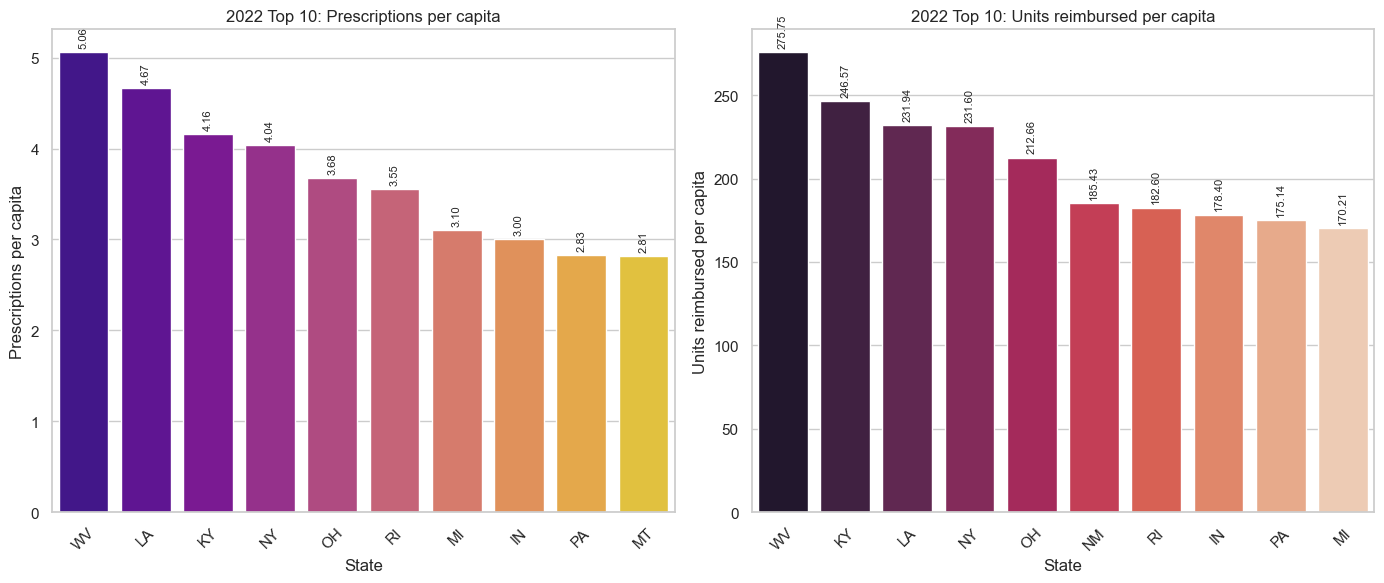

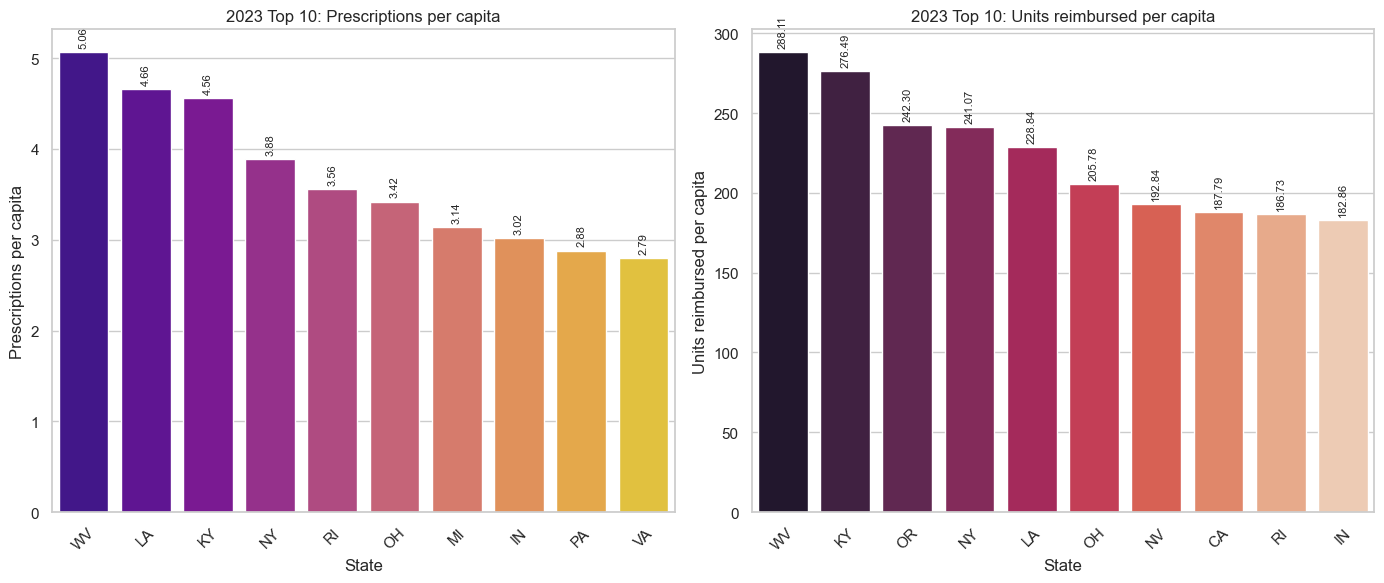

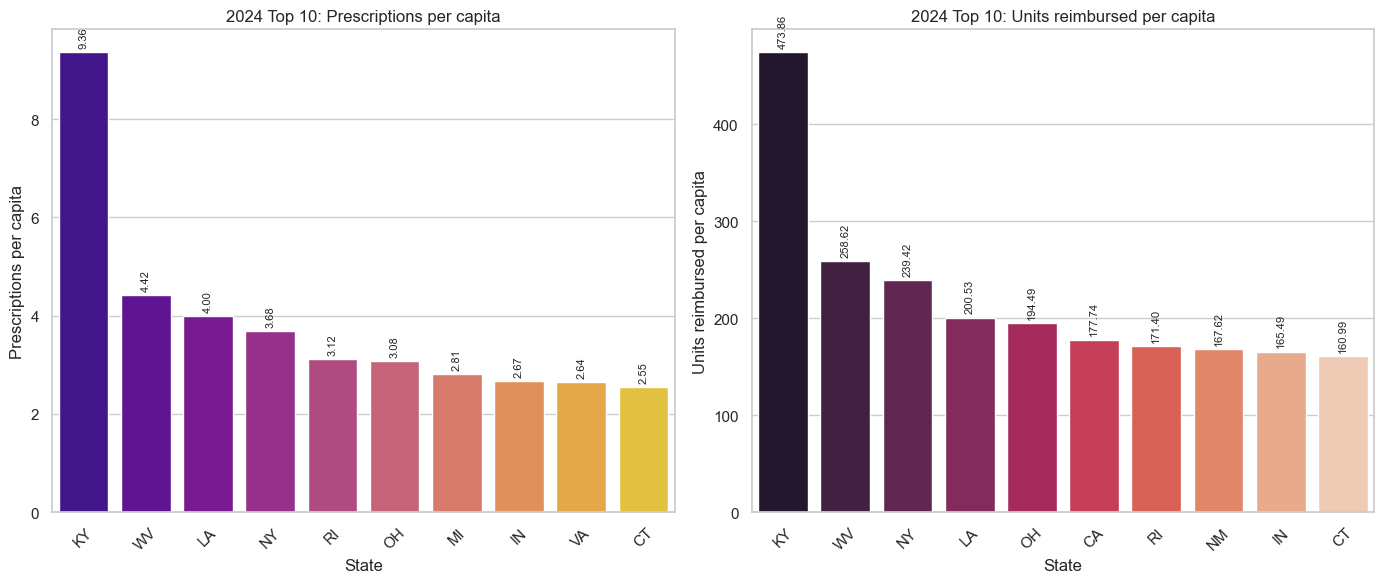

In [ ]:
# Patch seaborn.barplot to auto-add hue when only a palette is provided (suppresses deprecation warning)
if not getattr(sns, '_auto_hue_patched', False):
    _orig_barplot = sns.barplot

    def _barplot_auto_hue(*args, **kwargs):
        has_palette = 'palette' in kwargs and kwargs['palette'] is not None
        no_hue = 'hue' not in kwargs or kwargs['hue'] is None
        x_var = kwargs.get('x', None)
        # If a palette is passed without hue, replicate old behavior by using x as hue
        if has_palette and no_hue and x_var is not None:
            kwargs['hue'] = x_var
            # Single bar per category -> disable dodge
            kwargs.setdefault('dodge', False)
            # Hide legend (equivalent appearance to previous version)
            kwargs.setdefault('legend', False)
        return _orig_barplot(*args, **kwargs)

    sns.barplot = _barplot_auto_hue
    sns._auto_hue_patched = True
    
def _top_norm(year: int, col: str, n: int):
    """
    Return top n states for a given normalized column and year from the 'merged' dataframe.
    """
    dfy = merged[merged['Year'] == year]
    if dfy.empty:
        raise ValueError(f"No data available for year {year}")
    return (dfy[['State', col]]
            .dropna()
            .sort_values(col, ascending=False)
            .head(n))

def plot_top_ten_norms_side_by_side(year: int,
                                    n: int = 10,
                                    figsize=(14, 6),
                                    palettes=('plasma', 'rocket')):
    sns.set_theme(style='whitegrid')
    fig, axes = plt.subplots(1, 2, figsize=figsize)

    # Prescriptions (vertical bars)
    top_p = _top_norm(year, 'N Prescriptions norm', n)
    sns.barplot(data=top_p, x='State', y='N Prescriptions norm',
                ax=axes[0], palette=palettes[0])
    axes[0].set_title(f"{year} Top {n}: Prescriptions per capita")
    axes[0].set_xlabel('State')
    axes[0].set_ylabel('Prescriptions per capita')
    axes[0].tick_params(axis='x', rotation=45)
    for c in axes[0].containers:
        axes[0].bar_label(c, fmt='%.2f', padding=3, fontsize=8, rotation=90)

    # Units (vertical bars)
    top_u = _top_norm(year, 'N Units reimbursed norm', n)
    sns.barplot(data=top_u, x='State', y='N Units reimbursed norm',
                ax=axes[1], palette=palettes[1])
    axes[1].set_title(f"{year} Top {n}: Units reimbursed per capita")
    axes[1].set_xlabel('State')
    axes[1].set_ylabel('Units reimbursed per capita')
    axes[1].tick_params(axis='x', rotation=45)
    for c in axes[1].containers:
        axes[1].bar_label(c, fmt='%.2f', padding=3, fontsize=8, rotation=90)

    plt.tight_layout()
    return fig, axes

# Example
#plot_top_ten_norms_side_by_side(2010)
plot_top_ten_norms_side_by_side(2020)
plot_top_ten_norms_side_by_side(2021)
plot_top_ten_norms_side_by_side(2022)
plot_top_ten_norms_side_by_side(2023)
plot_top_ten_norms_side_by_side(2024)


In [ ]:
# Recreating years_iter function for population-normalized data
# Population-normalized ranking analysis (per-capita metrics) using 'merged'

norm_top_n = top_n if 'top_n' in globals() else 10
norm_records = []

def iter_norm_year_data():
    yrs = sorted(merged['Year'].unique())
    for yr in yrs:
        dfy = merged[merged['Year'] == yr]
        # Already aggregated; just set index
        yield yr, dfy.set_index('State')[['N Units reimbursed norm', 'N Prescriptions norm']]

for year, state_norm in iter_norm_year_data():
    if state_norm.empty:
        continue

    top_units_norm = (state_norm
                      .sort_values('N Units reimbursed norm', ascending=False)
                      .head(norm_top_n))
    top_presc_norm = (state_norm
                      .sort_values('N Prescriptions norm', ascending=False)
                      .head(norm_top_n))

    units_order_norm = list(top_units_norm.index)
    presc_order_norm = list(top_presc_norm.index)
    rank_units_norm = {s: i+1 for i, s in enumerate(units_order_norm)}
    rank_presc_norm = {s: i+1 for i, s in enumerate(presc_order_norm)}

    all_states_norm = list(dict.fromkeys(units_order_norm + presc_order_norm))

    print(f"\nYear {year}: Per-capita Rank Comparison (Top {norm_top_n})")
    print("State | Rank Units/Cap | Rank Presc/Cap | Same Position | Appearance")
    for s in all_states_norm:
        ru = rank_units_norm.get(s)
        rp = rank_presc_norm.get(s)
        if ru and rp:
            same = (ru == rp)
            appearance = "Both"
        elif ru and not rp:
            same = False
            appearance = "Units only"
        else:
            same = False
            appearance = "Prescriptions only"
        print(f"{s:>4}  | {str(ru or '-'):>13} | {str(rp or '-'):>13} | {str(same):>13} | {appearance}")

    for i, s in enumerate(units_order_norm, start=1):
        norm_records.append({'Year': year, 'Category': 'Units reimbursed per capita',
                             'Rank': i, 'State': s})
    for i, s in enumerate(presc_order_norm, start=1):
        norm_records.append({'Year': year, 'Category': 'Prescriptions per capita',
                             'Rank': i, 'State': s})

norm_top_states_df = pd.DataFrame(norm_records)

norm_counter_units = Counter(r['State'] for r in norm_records
                             if r['Category'] == 'Units reimbursed per capita')
norm_counter_presc = Counter(r['State'] for r in norm_records
                             if r['Category'] == 'Prescriptions per capita')

print("\nFrequency in Top (Units reimbursed per capita):")
print(norm_counter_units.most_common())

print("\nFrequency in Top (Prescriptions per capita):")
print(norm_counter_presc.most_common())

norm_exclusive = []
for yr in norm_top_states_df['Year'].unique():
    u_set = set(norm_top_states_df[(norm_top_states_df.Year == yr) &
                                   (norm_top_states_df.Category == 'Units reimbursed per capita')]['State'])
    p_set = set(norm_top_states_df[(norm_top_states_df.Year == yr) &
                                   (norm_top_states_df.Category == 'Prescriptions per capita')]['State'])
    only_u = u_set - p_set
    only_p = p_set - u_set
    for s in sorted(only_u):
        norm_exclusive.append({'Year': yr, 'State': s, 'Exclusive': 'Units per capita'})
    for s in sorted(only_p):
        norm_exclusive.append({'Year': yr, 'State': s, 'Exclusive': 'Prescriptions per capita'})

norm_exclusive_df = (pd.DataFrame(norm_exclusive)
                     .sort_values(['Year', 'Exclusive', 'State'])
                     .reset_index(drop=True))
print("\nStates appearing exclusively in one per-capita top list per year:")
print(norm_exclusive_df if not norm_exclusive_df.empty else "None")



Year 2010: Per-capita Rank Comparison (Top 10)
State | Rank Units/Cap | Rank Presc/Cap | Same Position | Appearance
  WV  |             1 |             1 |          True | Both
  NY  |             2 |             3 |         False | Both
  KY  |             3 |             2 |         False | Both
  IN  |             4 |             - |         False | Units only
  LA  |             5 |             5 |          True | Both
  ME  |             6 |             4 |         False | Both
  VT  |             7 |             6 |         False | Both
  WI  |             8 |             9 |         False | Both
  MO  |             9 |             8 |         False | Both
  DE  |            10 |             7 |         False | Both
  OH  |             - |            10 |         False | Prescriptions only

Year 2011: Per-capita Rank Comparison (Top 10)
State | Rank Units/Cap | Rank Presc/Cap | Same Position | Appearance
  WV  |             1 |             1 |          True | Both
  KY  |       